# Homework 2 - ECE 760 - Dario Placencio

### A Simplified Decision Tree
You are to implement a decision-tree learner for classification. To simplify your work, this will not be a general-purpose decision tree. Instead, your program can assume that:

- Each item has two continuous features (x1, x2) and a binary class label (y).
- Data files are in plaintext with one labeled item per line, separated by whitespace, as follows:

  - x11 x12 y1
  - ...
  - xn1 xn2 yn

Your program should implement a decision tree learner according to the following guidelines:

- Candidate splits (j, c) for numeric features should use a threshold c in feature dimension j in the form of xj ≥ c.
- c should be on values of that dimension present in the training data; i.e., the threshold is on training points, not in between training points. You may enumerate all features, and for each feature, use all possible values for that dimension.
- You may skip those candidate splits with zero split information (i.e., the entropy of the split) and continue the enumeration.
- The left branch of such a split is the "then" branch, and the right branch is "else."
- Splits should be chosen using information gain ratio. If there is a tie, you may break it arbitrarily.
- The stopping criteria (for making a node into a leaf) are that:
  - The node is empty, or
  - All splits have zero gain ratio (if the entropy of the split is non-zero), or
  - The entropy of any candidate split is zero.

To simplify, whenever there is no majority class in a leaf, let it predict y = 1.

### Program


Before building the decision tree, the tools that will be used for the calculations are defined. These are: entropy, information gain, information gain ratio, split information, and the best split.

#### Calculating Entropy

For a set 's'of binary classification entropy will be calculated as follows:

$\text{entropy}(S) = -p_+ \log_2(p_+) - p_- \log_2(p_-)$

where $p_+$ is the probability of a positive class and $p_-$ is the probability of a negative class on the label (y).

In [11]:
# Calculate entropy

import math

def entropy(y_values):
    if len(y_values) == 0:
        return 0
    p = sum(y_values) / len(y_values)
    if p == 0 or p == 1:
        return 0
    return -p*math.log2(p) - (1-p)*math.log2(1-p)

#### Calculating Information Gain and Gain Ratio

Information Gain is the difference in entropy from before to after the split:

$\text{Gain}(S, A) = \text{entropy}(S) - \sum_{t \in \{true, false\}} \frac{|S_t|}{|S|} \text{entropy}(S_t)$

where $S_t$ is the subset of examples for which attribute $A$ is true.

In [12]:
# Calculate information gain

def information_gain(data, feature_index, threshold):
    y_values = [y for _, y in data]
    entropy_before = entropy(y_values)
    
    left_y = [y for x, y in data if x[feature_index] >= threshold]
    right_y = [y for x, y in data if x[feature_index] < threshold]

    entropy_left = entropy(left_y)
    entropy_right = entropy(right_y)
    
    p_left = len(left_y) / len(data)
    p_right = len(right_y) / len(data)
    
    entropy_after = p_left * entropy_left + p_right * entropy_right
    
    return entropy_before - entropy_after

Gain Ratio is the ratio of Information Gain to the intrinsic information of the split:

$\text{GainRatio}(S, A) = \frac{\text{Gain}(S, A)}{\text{SplitInfo}(S, A)}$

where $\text{SplitInfo}(S, A) = -\sum_{t \in \{true, false\}} \frac{|S_t|}{|S|} \log_2 \frac{|S_t|}{|S|}$ represents the potential information generated by splitting the dataset S into A partitions.

In [13]:
def split_information(data, feature_index, threshold):
    left_y = [y for x, y in data if x[feature_index] >= threshold]
    right_y = [y for x, y in data if x[feature_index] < threshold]

    p_left = len(left_y) / len(data)
    p_right = len(right_y) / len(data)
    
    if p_left == 0 or p_right == 0:
        return 0
    
    return -p_left*math.log2(p_left) - p_right*math.log2(p_right)

def gain_ratio(data, feature_index, threshold):
    gain = information_gain(data, feature_index, threshold)
    split_info = split_information(data, feature_index, threshold)
    
    if split_info == 0: # Avoid division by zero
        return 0
    
    return gain / split_info

#### Best Split

Best split is the split that maximizes the information gain ratio, considering all possible splits for each feature, and the use of the threshold c in feature dimension j in the form of xj ≥ c.

In [14]:
# Calculating split information
def best_split(data):
    best_gain_ratio = 0
    best_feature = None
    best_threshold = None

    for feature_index in [0, 1]:
        thresholds = set(x[feature_index] for x, _ in data)
        for threshold in thresholds:
            gain_ratio_val = gain_ratio(data, feature_index, threshold)
            if gain_ratio_val > best_gain_ratio:
                best_gain_ratio = gain_ratio_val
                best_feature = feature_index
                best_threshold = threshold

    return best_feature, best_threshold, best_gain_ratio

#### Building the Decision Tree

Through a recursive process, the decision tree is built. The process is as follows:

In [118]:
class Node:
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, value=None):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

def build_tree(data):
    y_values = [y for _, y in data]
    
    # Check stopping criteria
    if not data or entropy(y_values) == 0:
        return Node(value=(1 if sum(y_values) / len(data) >= 0.5 else 0))
    
    feature_index, threshold, gain = best_split(data)
    
    if gain == 0:
        return Node(value=(1 if sum(y_values) / len(data) >= 0.5 else 0))

    left_data = [d for d in data if d[0][feature_index] >= threshold]
    right_data = [d for d in data if d[0][feature_index] < threshold]

    left_node = build_tree(left_data)
    right_node = build_tree(right_data)

    return Node(feature_index, threshold, left_node, right_node)

#### Building Loader

In [119]:
def load_data(filename):
    data = []
    with open(filename, 'r') as f:
        for line in f:
            x1, x2, y = map(float, line.strip().split())
            data.append(((x1, x2), int(y)))
    return data

#### All Together

In [17]:
def print_tree(node, spacing=""):
    if node.value is not None:
        print(spacing + "Predict", node.value)
        return

    print(spacing + f"[Feature {node.feature_index} >= {node.threshold}]")
    print(spacing + '--> True:')
    print_tree(node.left, spacing + "  ")

    print(spacing + '--> False:')
    print_tree(node.right, spacing + "  ")

if __name__ == "__main__":
    data = load_data("Druns.txt")
    tree = build_tree(data)
    print_tree(tree)

[Feature 1 >= 8.0]
--> True:
  Predict 1
--> False:
  [Feature 1 >= 0.0]
  --> True:
    [Feature 1 >= 6.0]
    --> True:
      [Feature 1 >= 7.0]
      --> True:
        Predict 0
      --> False:
        Predict 1
    --> False:
      Predict 0
  --> False:
    [Feature 0 >= 0.1]
    --> True:
      Predict 0
    --> False:
      Predict 1


### Questions

1. (Our algorithm stops at pure labels) [10 pts] If a node is not empty but contains training items with the same label, why is it guaranteed to become a leaf?  Explain. You may assume that the feature values of these items are not all the same. 

If a node contains training items with the same label, then the entropy of the node is \(0\). This is because entropy measures the amount of uncertainty or randomness in a set. If all the labels are the same, there is no uncertainty. The formula for entropy is:

$\text{entropy}(S) = -p_+ \log_2(p_+) - p_- \log_2(p_-)$

Where:

- \( p_+ \) is the proportion of positive examples in \( S \).
- \( p_- \) is the proportion of negative examples in \( S \).


In the case where all examples have the same label, one of the proportions (either \( p_+ \) or \( p_- \)) will be \(1\), and the other will be \(0\). This results in an entropy of \(0\).
Given our decision tree's stopping criterion, if the entropy of a node is \(0\), we make that node a leaf. This is because there is no benefit to splitting a node with zero entropy further: we already have a perfectly accurate classification for the training items in that node.

2. (Our algorithm is greedy)  [10 pts] Handcraft a small training set where both classes are present but the algorithm refuses to split; instead it makes the root a leaf and stop;
Importantly, if we were to manually force a split, the algorithm will happily continue splitting the data set further and produce a deeper tree with zero training error.
You should (1) plot your training set, (2) explain why.  Hint: you don't need more than a handful of items.

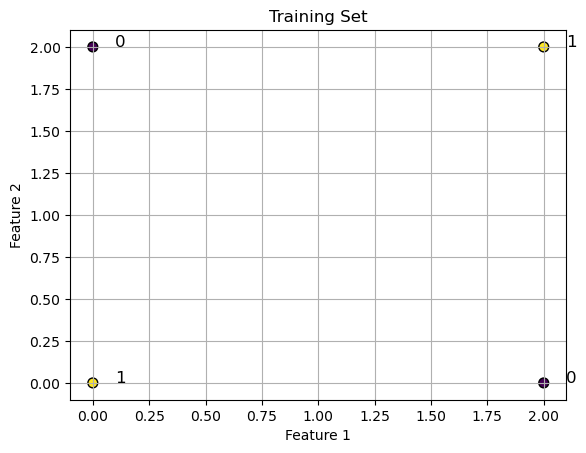

In [18]:
# Crafting a small training set

import numpy as np
import matplotlib.pyplot as plt

# Create a small training set in the shape of a box
X = np.array([[0, 2], [2, 2], [2, 0], [0, 0]])
y = np.array([0, 1, 0, 1])

# Plot the training set
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', s=50, edgecolors='k')
for point, label in zip(X, y):
    plt.text(point[0]+0.1, point[1], str(label), fontsize=12)

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Training Set')
plt.grid(True)
plt.show();

In this specially created dataset, we have two groups labeled as 0 and 1, but if we look at the values of our features, there's no easy way to separate these groups with just one question (split). The data points are all mixed up, and there's no obvious first question we can ask to neatly separate the groups.

The Decision Tree algorithm wants to ask questions to figure things out. However, when it looks at this data, it can't find a good first question to start with. So, it stops at the very beginning, and will make the root node a leaf.

If we manually force a split at any feature, the algorithm will continue splitting the data further, producing a deeper tree with zero training error, but it will still start as a leaf node if no informative split is found at the root, like on this case.

3. (Information gain ratio exercise)  [10 pts] Use the training set Druns.txt.  For the root node, list all candidate cuts and their information gain ratio. If the entropy of the candidate split is zero, please list its mutual information (i.e. information gain). Hint: to get $\log_2(x)$ when your programming language may be using a different base, use \verb|log(x)/log(2)|. Also, please follow the split rule in the first section.


In [19]:
# Compute the information gain ratio for each candidate cut
def list_candidate_cuts(data):
    for feature_index in [0, 1]:
        thresholds = set(x[feature_index] for x, _ in data)
        for threshold in thresholds:
            gain = information_gain(data, feature_index, threshold)
            split_info = split_information(data, feature_index, threshold)
            
            if split_info == 0:  # mutual information
                print(f"Feature {feature_index}, Threshold {threshold}: Mutual Information = {gain}")
            else:
                gain_ratio_val = gain / split_info
                print(f"Feature {feature_index}, Threshold {threshold}: Gain Ratio = {gain_ratio_val:.4f}")

if __name__ == "__main__":
    data = load_data("Druns.txt")
    list_candidate_cuts(data)

Feature 0, Threshold 0.1: Gain Ratio = 0.1005
Feature 0, Threshold 0.0: Mutual Information = 0.0
Feature 1, Threshold 0.0: Gain Ratio = 0.0560
Feature 1, Threshold 1.0: Gain Ratio = 0.0058
Feature 1, Threshold 2.0: Gain Ratio = 0.0011
Feature 1, Threshold 3.0: Gain Ratio = 0.0164
Feature 1, Threshold 4.0: Gain Ratio = 0.0497
Feature 1, Threshold 5.0: Gain Ratio = 0.1112
Feature 1, Threshold 6.0: Gain Ratio = 0.2361
Feature 1, Threshold 7.0: Gain Ratio = 0.0560
Feature 1, Threshold 8.0: Gain Ratio = 0.4302
Feature 1, Threshold -1.0: Gain Ratio = 0.1005
Feature 1, Threshold -2.0: Mutual Information = 0.0


For the root node, considering the candidate cuts on the dataset Druns.txt, we can observe the following Information Gain Ratios (GR) and Information Gains (IG) for each threshold value:

For Feature 0 (x1):

- Threshold 0.0: Mutual Information = 0.0
- Threshold 0.1: Gain Ratio = 0.1005

For Feature 1 (x2):

- Threshold -2.0: Mutual Information = 0.0
- Threshold -1.0: Gain Ratio = 0.1005
- Threshold 0.0: Gain Ratio = 0.0560
- Threshold 1.0: Gain Ratio = 0.0058
- Threshold 2.0: Gain Ratio = 0.0011
- Threshold 3.0: Gain Ratio = 0.0164
- Threshold 4.0: Gain Ratio = 0.0497
- Threshold 5.0: Gain Ratio = 0.1112
- Threshold 6.0: Gain Ratio = 0.2361
- Threshold 7.0: Gain Ratio = 0.0560
- Threshold 8.0: Gain Ratio = 0.4302

There are two unique values for Feature 0 (x1) that were tested as potential splits. One of the splits (Threshold 0.0) had an entropy of 0 (meaning it was a perfect split for the data it was given) and thus its mutual information is listed.

For feature 1 (x2) had many more unique values and hence more potential splits were tested. While most thresholds provided some amount of gain, the one at Threshold 8.0 offered the highest gain ratio of 0.4302, indicating that it might be the most informative split if you were to select the first split for a decision tree based purely on gain ratio.

Similarly, for Feature 1 with Threshold -2.0, the entropy of the candidate split is 0, so mutual information is displayed.

4. (The king of interpretability)  [10 pts] Decision tree is not the most accurate classifier in general.  However, it persists.  This is largely due to its rumored interpretability: a data scientist can easily explain a tree to a non-data scientist.  Build a tree from D3leaves.txt.  Then manually convert your tree to a set of logic rules.  Show the tree\footnote{When we say show the tree, we mean either the standard computer science tree view, or some crude plaintext representation of the tree -- as long as you explain the format.  When we say visualize the tree, we mean a plot in the 2D $x$ space that shows how the tree will classify any points.} and the rules.


In [20]:
# Read D3leaves.txt
df3 = load_data("D3leaves.txt")

In [21]:
# Build the tree
root = build_tree(df3)

In [22]:
# Print the tree
print_tree(root)

[Feature 0 >= 10.0]
--> True:
  Predict 1
--> False:
  [Feature 1 >= 3.0]
  --> True:
    Predict 1
  --> False:
    Predict 0


Rules of the Tree:

- IF $(x_1 \geq 10.0)$ THEN class = 1
- IF $(x_1 < 10.0)$ AND $(x_2 \geq 3.0)$ THEN class = 1
- IF $(x_1 < 10.0)$ AND $(x_2 < 3.0)$ THEN class = 0

5. (Or is it?)  [10 pts] For this question only, make sure you DO NOT VISUALIZE the data sets or plot your tree's decision boundary in the 2D $x$ space.  If your code does that, turn it off before proceeding.  This is because you want to see your own reaction when trying to interpret a tree.  You will get points no matter what your interpretation is.
And we will ask you to visualize them in the next question anyway.

- Build a decision tree on D1.txt. Show it to us in any format (e.g. could be a standard binary tree with
nodes and arrows, and denote the rule at each leaf node; or as simple as plaintext output where each
line represents a node with appropriate line number pointers to child nodes; whatever is convenient
for you). Again, do not visualize the data set or the tree in the x input space. In real tasks you will not
be able to visualize the whole high dimensional input space anyway, so we don’t want you to “cheat”
here.

In [23]:
# Read D1.txt
df1 = load_data('D1.txt')

In [24]:
# Build the tree
root = build_tree(df1)

In [25]:
# Print the tree
print_tree(root)

[Feature 1 >= 0.201829]
--> True:
  Predict 1
--> False:
  Predict 0


- Look at your tree in the above format (remember, you should not visualize the 2D dataset or your
tree’s decision boundary) and try to interpret the decision boundary in human understandable English.

From the decision tree built on D1.txt, only a single split is made, with the rule being:

- If X2 is greater than or equal to 0.201829, then the class is 1.
- If X2 is less than 0.201829, then the class is 0.

Regarding the decision boundary is difficult to interpret the total lack of knowledge of the magnitude of the features. However, we can say that the decision boundary is a vertical line at X2 = 0.201829.

- Build a decision tree on D2.txt. Show it to us.

In [26]:
# Read D2.txt
df2 = load_data('D2.txt')
        
# Build the tree
root2 = build_tree(df2)

In [27]:
# Print the tree
print_tree(root2)

[Feature 0 >= 0.533076]
--> True:
  [Feature 1 >= 0.228007]
  --> True:
    [Feature 1 >= 0.424906]
    --> True:
      Predict 1
    --> False:
      [Feature 0 >= 0.708127]
      --> True:
        Predict 1
      --> False:
        [Feature 1 >= 0.32625]
        --> True:
          [Feature 0 >= 0.595471]
          --> True:
            [Feature 0 >= 0.646007]
            --> True:
              Predict 1
            --> False:
              [Feature 1 >= 0.403494]
              --> True:
                Predict 1
              --> False:
                Predict 0
          --> False:
            Predict 0
        --> False:
          Predict 0
  --> False:
    [Feature 0 >= 0.887224]
    --> True:
      [Feature 1 >= 0.037708]
      --> True:
        [Feature 1 >= 0.082895]
        --> True:
          Predict 1
        --> False:
          [Feature 0 >= 0.960783]
          --> True:
            Predict 1
          --> False:
            Predict 0
      --> False:
        Predict 0
 

- Try to interpret your D2 decision tree. Is it easy or possible to do so without visualization?

So, this case is the totally of oposit, with many splits being made. From here I could suggest that the tree is more complex, and sensitive to the features, hence the need for more splits. However, I'm not sure if this is the case, without visualizing the data, so it's difficult to interpret the decision tree.

6. (Hypothesis space) [10 pts] For D1.txt and D2.txt, do the following separately:


In [70]:
import numpy as np
import pandas as pd

In [85]:
# Read D1.txt
with open('D1.txt', 'r') as file:
    df2 = [tuple(map(float, line.split())) for line in file]

In [96]:
# Read D2.txt
with open('D2.txt', 'r') as file:
    df2 = [tuple(map(float, line.split())) for line in file]

In [90]:
# Define predict function
def predict(node, x):
    if node.value is not None:
        return node.value
    
    if x[node.feature_index] >= node.threshold:
        return predict(node.left, x)
    else:
        return predict(node.right, x)

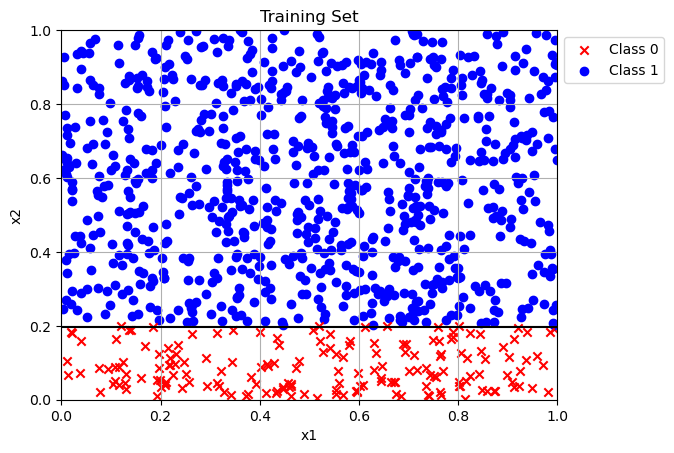

In [92]:
# Produce a scatter plot of the data set.
for x, y, label in df1:
    if label == 0:
        plt.scatter(x, y, color='red', marker='x')
    else:
        plt.scatter(x, y, color='blue', marker='o')
      
# Plot the decision boundary
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x, y)
Z = np.array([predict(root, (x, y)) for x, y in zip(np.ravel(X), np.ravel(Y))])
Z = Z.reshape(X.shape)
plt.contour(X, Y, Z, [0.5], colors='black')
  
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Training Set')
plt.legend(["Class 0", "Class 1"], loc ="upper left", bbox_to_anchor =(1, 1))
plt.grid(True)
plt.show();

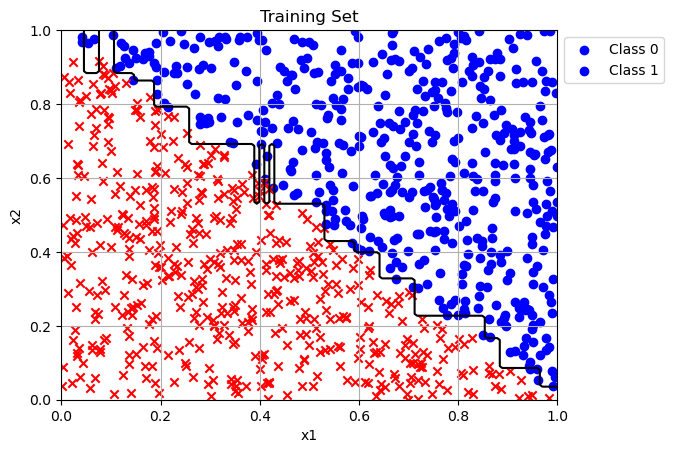

In [98]:
# Produce a scatter plot of the data set.
for x, y, label in df2:
    if label == 0:
        plt.scatter(x, y, color='red', marker='x')
    else:
        plt.scatter(x, y, color='blue', marker='o')
      
# Plot the decision boundary
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x, y)    
Z = np.array([predict(root2, (x, y)) for x, y in zip(np.ravel(X), np.ravel(Y))])
Z = Z.reshape(X.shape)
plt.contour(X, Y, Z, [0.5], colors='black')

plt.xlabel('x1')
plt.ylabel('x2')    
plt.title('Training Set')
plt.legend(["Class 0", "Class 1"], loc ="upper left", bbox_to_anchor =(1, 1))
plt.grid(True)
plt.show();

It can be observed the difference in complexity for D2 compared to D1, the distribution of the labels on D1 makes the tree quite simple, considering the strong effect of X2 on the label. On the case of D2 is the oposit, the distribution of the labels is more complex, and the effect of X1 and X2 is not as strong as in D1, hence the need for more splits.  

7. (Learning curve)  [20 pts] We provide a data set Dbig.txt with 10000 labeled items.  Caution: Dbig.txt is sorted.

In [121]:
# Read Dbig.txt
dbig = load_data('Dbig.txt')

- You will randomly split Dbig.txt into a candidate training set of 8192 items and a test set (the rest).  Do this by generating a random permutation, and split at 8192.

In [122]:
# Randomly split Dbig.txt into two sets: Dtrain.txt (8192 items) and Dtest.txt (rest)
np.random.seed(0)   
np.random.shuffle(dbig)
Dtrain = dbig[:8192]
Dtest = dbig[8192:]

- Generate a sequence of five nested training sets $D_{32} \subset D_{128} \subset D_{512} \subset D_{2048} \subset D_{8192}$ from the candidate training set.  The subscript $n$ in $D_n$ denotes training set size.  The easiest way is to take the first $n$ items from the (same) permutation above.  This sequence simulates the real world situation where you obtain more and more training data.
  

In [123]:
# Five nested training sets of size 32, 128, 512, 2048, and 8192
np.random.seed(0)
np.random.shuffle(Dtrain)
Dtrain32 = Dtrain[:32]
Dtrain128 = Dtrain[:128]
Dtrain512 = Dtrain[:512]
Dtrain2048 = Dtrain[:2048]
Dtrain8192 = Dtrain[:8192]

- For each $D_n$ above, train a decision tree.  Measure its test set error $err_n$.  Show three things in your answer: (1) List $n$, number of nodes in that tree, $err_n$. (2) Plot $n$ vs. $err_n$.  This is known as a learning curve (a single plot). (3) Visualize your decision trees' decision boundary (five plots). \\
 

In [124]:
# Traing a decision tree on each of the five training sets
root32 = build_tree(Dtrain32)
root128 = build_tree(Dtrain128)
root512 = build_tree(Dtrain512)
root2048 = build_tree(Dtrain2048)
root8192 = build_tree(Dtrain8192)

In [126]:
# Measure the test error of each tree
def test_error(root, data):
    return sum(predict(root, x) != y for x, y in data) / len(data)

print(f"Test error of the tree trained on Dtrain32: {test_error(root32, Dtest):.4f}")
print(f"Test error of the tree trained on Dtrain128: {test_error(root128, Dtest):.4f}")
print(f"Test error of the tree trained on Dtrain512: {test_error(root512, Dtest):.4f}")
print(f"Test error of the tree trained on Dtrain2048: {test_error(root2048, Dtest):.4f}")
print(f"Test error of the tree trained on Dtrain8192: {test_error(root8192, Dtest):.4f}")

Test error of the tree trained on Dtrain32: 0.1836
Test error of the tree trained on Dtrain128: 0.0725
Test error of the tree trained on Dtrain512: 0.0614
Test error of the tree trained on Dtrain2048: 0.0238
Test error of the tree trained on Dtrain8192: 0.0127


In [128]:
# List the number of nodes on each tree
def count_nodes(root):
    if root.value is not None:
        return 1
    return 1 + count_nodes(root.left) + count_nodes(root.right)

print(f"Number of nodes on the tree trained on Dtrain32: {count_nodes(root32)}")
print(f"Number of nodes on the tree trained on Dtrain128: {count_nodes(root128)}")
print(f"Number of nodes on the tree trained on Dtrain512: {count_nodes(root512)}")  
print(f"Number of nodes on the tree trained on Dtrain2048: {count_nodes(root2048)}")
print(f"Number of nodes on the tree trained on Dtrain8192: {count_nodes(root8192)}")

Number of nodes on the tree trained on Dtrain32: 17
Number of nodes on the tree trained on Dtrain128: 23
Number of nodes on the tree trained on Dtrain512: 59
Number of nodes on the tree trained on Dtrain2048: 121
Number of nodes on the tree trained on Dtrain8192: 291


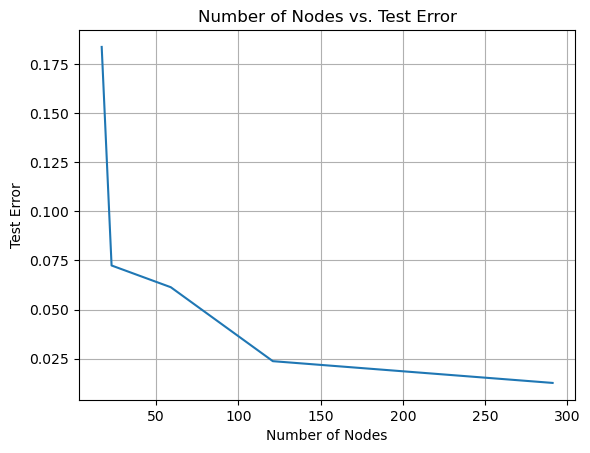

In [129]:
# Plot number of nodes vs. test error (Learning Curve)
nodes = [count_nodes(root32), count_nodes(root128), count_nodes(root512), count_nodes(root2048), count_nodes(root8192)]
errors = [test_error(root32, Dtest), test_error(root128, Dtest), test_error(root512, Dtest), test_error(root2048, Dtest), test_error(root8192, Dtest)]

plt.plot(nodes, errors)
plt.xlabel('Number of Nodes')
plt.ylabel('Test Error')
plt.title('Number of Nodes vs. Test Error')
plt.grid(True)
plt.show();

In [131]:
# Visualize each tree decision boundary
def visualize(root, data):
    for x, y in data:
        if y == 0:
            plt.scatter(x[0], x[1], color='red', marker='x')
        else:
            plt.scatter(x[0], x[1], color='blue', marker='o')
    
    x = np.linspace(0, 1, 100)
    y = np.linspace(0, 1, 100)
    X, Y = np.meshgrid(x, y)
    Z = np.array([predict(root, (x, y)) for x, y in zip(np.ravel(X), np.ravel(Y))])
    Z = Z.reshape(X.shape)
    plt.contour(X, Y, Z, [0.5], colors='black')
    
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title('Training Set')
    plt.legend(["Class 0", "Class 1"], loc ="upper left", bbox_to_anchor =(1, 1))
    plt.grid(True)
    plt.show();

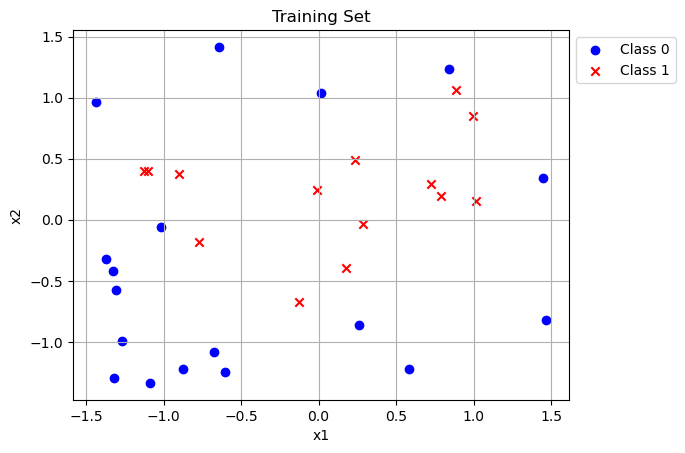

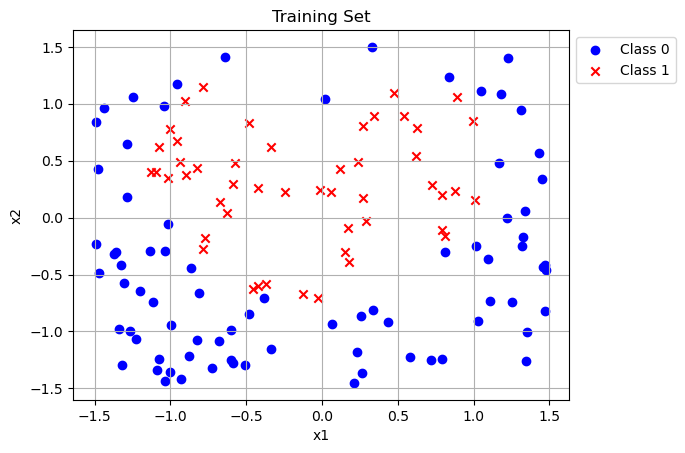

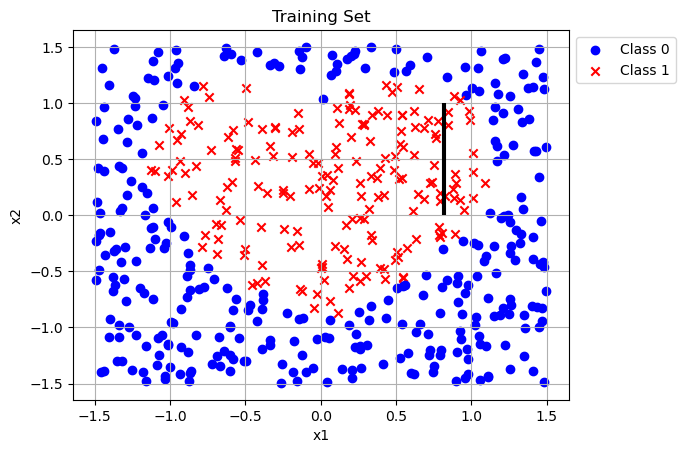

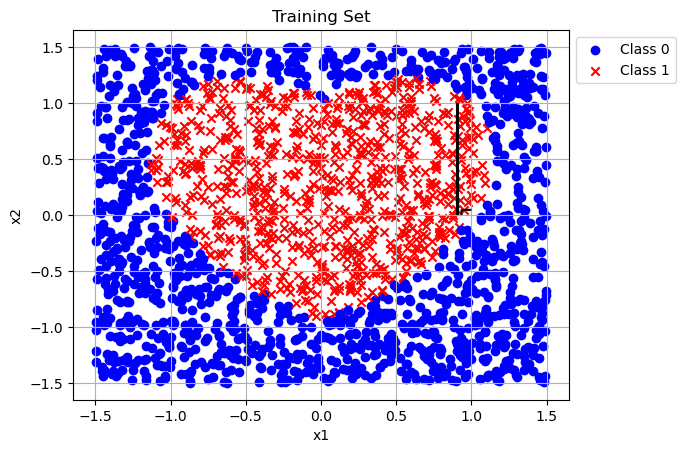

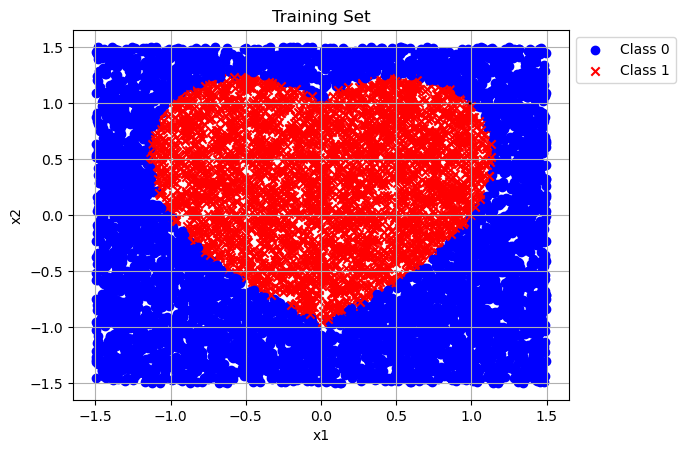

In [132]:
visualize(root32, Dtrain32)
visualize(root128, Dtrain128)
visualize(root512, Dtrain512)
visualize(root2048, Dtrain2048)
visualize(root8192, Dtrain8192)

Cute detail.

### 3. sklearn [10 pts]

Learn to use sklearn (\url{https://scikit-learn.org/stable/}).

Use sklearn.tree.DecisionTreeClassifier to produce trees for datasets $D_{32}, D_{128}, D_{512}, D_{2048}, D_{8192}$.  Show two things in your answer: (1) List $n$, number of nodes in that tree, $err_n$. (2) Plot $n$ vs. $err_n$.

In [133]:
# import sklearn
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [135]:
# Train decision trees using sklearn on each of the five training sets
clf32 = DecisionTreeClassifier()
clf32.fit([x for x, _ in Dtrain32], [y for _, y in Dtrain32])

clf128 = DecisionTreeClassifier()
clf128.fit([x for x, _ in Dtrain128], [y for _, y in Dtrain128])

clf512 = DecisionTreeClassifier()
clf512.fit([x for x, _ in Dtrain512], [y for _, y in Dtrain512])

clf2048 = DecisionTreeClassifier()
clf2048.fit([x for x, _ in Dtrain2048], [y for _, y in Dtrain2048])

clf8192 = DecisionTreeClassifier()
clf8192.fit([x for x, _ in Dtrain8192], [y for _, y in Dtrain8192])

DecisionTreeClassifier()

In [137]:
# Measure the test error of each tree   

print(f"Test error of the tree trained on Dtrain32: {1 - accuracy_score([y for _, y in Dtest], clf32.predict([x for x, _ in Dtest])):.4f}")
print(f"Test error of the tree trained on Dtrain128: {1 - accuracy_score([y for _, y in Dtest], clf128.predict([x for x, _ in Dtest])):.4f}")
print(f"Test error of the tree trained on Dtrain512: {1 - accuracy_score([y for _, y in Dtest], clf512.predict([x for x, _ in Dtest])):.4f}")
print(f"Test error of the tree trained on Dtrain2048: {1 - accuracy_score([y for _, y in Dtest], clf2048.predict([x for x, _ in Dtest])):.4f}")
print(f"Test error of the tree trained on Dtrain8192: {1 - accuracy_score([y for _, y in Dtest], clf8192.predict([x for x, _ in Dtest])):.4f}")

Test error of the tree trained on Dtrain32: 0.2063
Test error of the tree trained on Dtrain128: 0.0791
Test error of the tree trained on Dtrain512: 0.0503
Test error of the tree trained on Dtrain2048: 0.0227
Test error of the tree trained on Dtrain8192: 0.0100


(1) List $n$, number of nodes in that tree, $err_n$.

In [138]:
# List the number of nodes on each tree
def count_nodes(root):
    return root.tree_.node_count

print(f"Number of nodes on the tree trained on Dtrain32: {count_nodes(clf32)}")
print(f"Number of nodes on the tree trained on Dtrain128: {count_nodes(clf128)}")
print(f"Number of nodes on the tree trained on Dtrain512: {count_nodes(clf512)}")
print(f"Number of nodes on the tree trained on Dtrain2048: {count_nodes(clf2048)}")
print(f"Number of nodes on the tree trained on Dtrain8192: {count_nodes(clf8192)}")

Number of nodes on the tree trained on Dtrain32: 19
Number of nodes on the tree trained on Dtrain128: 23
Number of nodes on the tree trained on Dtrain512: 59
Number of nodes on the tree trained on Dtrain2048: 95
Number of nodes on the tree trained on Dtrain8192: 249


(2) Plot $n$ vs. $err_n$.

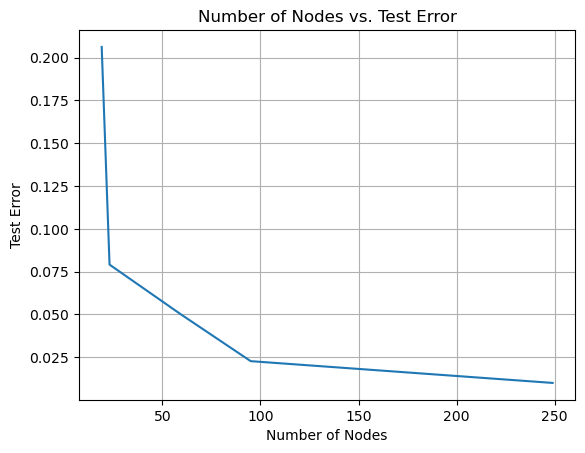

In [140]:
# Plot number of nodes vs. test error (Learning Curve)
nodes = [count_nodes(clf32), count_nodes(clf128), count_nodes(clf512), count_nodes(clf2048), count_nodes(clf8192)]

errors = [1 - accuracy_score([y for _, y in Dtest], clf32.predict([x for x, _ in Dtest])),
            1 - accuracy_score([y for _, y in Dtest], clf128.predict([x for x, _ in Dtest])),
            1 - accuracy_score([y for _, y in Dtest], clf512.predict([x for x, _ in Dtest])),
            1 - accuracy_score([y for _, y in Dtest], clf2048.predict([x for x, _ in Dtest])),
            1 - accuracy_score([y for _, y in Dtest], clf8192.predict([x for x, _ in Dtest]))]

plt.plot(nodes, errors)
plt.xlabel('Number of Nodes')
plt.ylabel('Test Error')
plt.title('Number of Nodes vs. Test Error')
plt.grid(True)
plt.show();

### 4. Lagrange Interpolation [10 pts]

Fix some interval $[a, b]$ and sample $n = 100$ points $x$ from this interval uniformly. Use these to build a training set consisting of $n$ pairs $(x, y)$ by setting function $y = sin(x)$. \\

In [1]:
from scipy.interpolate import lagrange
from sklearn.metrics import mean_squared_error

In [3]:
# Function to compute log mean squared error
def log_mse(y_true, y_pred):
    return np.log(mean_squared_error(y_true, y_pred))

In [4]:
# Generate training data
a, b = 0, 2 * np.pi
n = 100
x_train = np.linspace(a, b, n)
y_train = np.sin(x_train)

In [5]:
# Generate model using Lagrange interpolation
f = lagrange(x_train, y_train)

In [6]:
# Generate test data
x_test = np.random.uniform(a, b, n)
y_test = np.sin(x_test)

In [7]:
# Predict using the Lagrange interpolation
y_train_pred = f(x_train)
y_test_pred = f(x_test)

In [11]:
# Compute log mean squared error
print("Train Log MSE:", log_mse(y_train, y_train_pred))
print("Test Log MSE:", log_mse(y_test, y_test_pred))

Train Log MSE: 318.70422334385216
Test Log MSE: 318.2869378920832


It can be observed that errors for train and test are relatively similar, but both have a considerable magnitude that might be the nature of the interpolation method, specially considering the big number of points used for the interpolation.

In [19]:
# Create list
sd = []
train_errors = []
test_errors = []

In [20]:
# Add Gaussian noise to the training data
for std_dev in [0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10, 20, 50, 100, 200]:
    noise = np.random.normal(0, std_dev, n)
    x_train_noisy = x_train + noise
    y_train_noisy = np.sin(x_train_noisy)
    
    # Generate model using Lagrange interpolation with noisy data
    f_noisy = lagrange(x_train_noisy, y_train_noisy)
    
    # Predict using the Lagrange interpolation
    y_train_pred_noisy = f_noisy(x_train_noisy)
    y_test_pred_noisy = f_noisy(x_test)
    
    # Compute log mean squared error
    print("\nStandard Deviation for ε:", std_dev)
    print("Train Log MSE with noise:", log_mse(y_train_noisy, y_train_pred_noisy))
    print("Test Log MSE with noise:", log_mse(y_test, y_test_pred_noisy))
    
    # Store the sd value and error values
    sd.append(std_dev)
    train_errors.append(log_mse(y_train_noisy, y_train_pred_noisy))
    test_errors.append(log_mse(y_test, y_test_pred_noisy))


Standard Deviation for ε: 0.01
Train Log MSE with noise: 315.25163249997024
Test Log MSE with noise: 314.9247850228943

Standard Deviation for ε: 0.05
Train Log MSE with noise: 327.45204183538505
Test Log MSE with noise: 326.11489189153775

Standard Deviation for ε: 0.1
Train Log MSE with noise: 331.77576279214566
Test Log MSE with noise: 331.61899360897263

Standard Deviation for ε: 0.5
Train Log MSE with noise: 338.7801185123282
Test Log MSE with noise: 327.8144428806697

Standard Deviation for ε: 1
Train Log MSE with noise: 337.24664758170405
Test Log MSE with noise: 307.3834590815007

Standard Deviation for ε: 2
Train Log MSE with noise: 306.8126721090683
Test Log MSE with noise: 268.4591202876754

Standard Deviation for ε: 5
Train Log MSE with noise: 317.6132495031767
Test Log MSE with noise: 171.32280549372015

Standard Deviation for ε: 10
Train Log MSE with noise: 285.12607644574155
Test Log MSE with noise: 81.61956340637005

Standard Deviation for ε: 20
Train Log MSE with nois

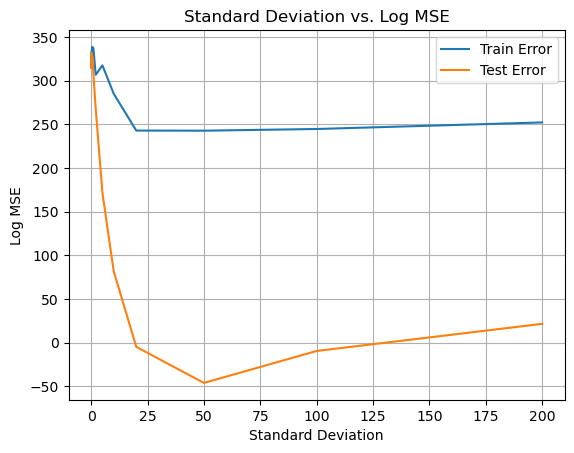

In [25]:
# Plot sd, vs. train and test errors
plt.plot(sd, train_errors, label='Train Error')
plt.plot(sd, test_errors, label='Test Error')
plt.xlabel('Standard Deviation')
plt.ylabel('Log MSE')   
plt.title('Standard Deviation vs. Log MSE')
plt.legend(loc='upper right')
plt.grid(True)
plt.show();

It can be observed that when Gaussian noise is introduced to the training data for Lagrange interpolation, the model's performance initially improves with moderate noise levels, likely due to noise acting as a regularizer and preventing overfitting. However, there's an optimal noise threshold (around a standard deviation of 10) beyond which the performance starts to decline. Essentially, a certain amount of noise can enhance the model's generalization, but excessive noise deteriorates its capability.